In [49]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import json
from sklearn.decomposition import NMF


## API

In [ ]:
BASE_WORKS = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/works"
BASE_WORK_TITLES = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/works"
BASE_TITLES = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles"

In [2]:
API_KEY = "fh5hj47dynk4nvx4s9ewufj4"

In [3]:
DOMAIN = "PRH.US"

BASE_WORKS = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/works"
BASE_TITLE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles"

In [4]:
def get_works_page(start, rows, on_sale_from):
    params = {
        "api_key": API_KEY,
        "rows": rows,
        "start": start,
        "preferLanguage": "E",
        "ageRangeMax": 18,
        "ageRangeMin": 7,
        "showPublishedBooks": "true",
        "showComingSoon": "false",
        "showNewReleases": "true",
        "showFlapCopy": "true",
        "suppressLinks": "true",
        "suppressRecordCount": "true",
        "onSaleFrom": on_sale_from,  # mm/dd/yyyy
    }

    r = requests.get(BASE_WORKS, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    # IMPORTANT: works list is here
    return data["data"]["works"]

In [5]:
def get_work_titles(workId):
    url = f"{BASE_WORK_TITLES}/{workId}/titles"
    params = {"api_key": API_KEY}

    r = requests.get(url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    # The correct structure for your API:
    # { "titles": [ {...}, {...}, ... ] }
    titles = data.get("titles", [])

    # Guarantee titles is a list of dicts
    if isinstance(titles, list):
        titles = [t for t in titles if isinstance(t, dict)]
    else:
        titles = []

    return titles

In [6]:
def fetch_title(isbn):
    url = f"{BASE_TITLES}/{isbn}"
    params = {"api_key": API_KEY}

    r = requests.get(url, params=params, timeout=15)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def extract_description(title_data):
    for field in ["flapCopy", "description", "longDescription", "shortDescription"]:
        if field in title_data and title_data[field]:
            return title_data[field]
    return None

In [7]:
def collect_corpus(max_titles=1000):
    one_year_ago = (datetime.now() - timedelta(days=365)).strftime("%m/%d/%Y")

    isbns = []
    texts = []

    start = 0
    rows = 20

    while len(isbns) < max_titles:

        works = get_works_page(start=start, rows=rows, on_sale_from=one_year_ago)
        if not works:
            break

        for w in works:
            workId = w.get("workId")
            if not workId:
                continue

            # Fetch titles for this work
            title_records = get_work_titles(workId)

            title_records = get_work_titles(workId)

            for t in title_records:
                isbn = t.get("isbn")
                if not isbn:
                    continue

                # Fetch description
                title_data = fetch_title(isbn)
                if not title_data:
                    continue

                desc = extract_description(title_data)
                if not desc:
                    continue

                isbns.append(isbn)
                texts.append(desc)

                if len(isbns) >= max_titles:
                    break

            if len(isbns) >= max_titles:
                break

        start += rows
        time.sleep(0.2)

    return isbns, texts


In [8]:
sample_titles = get_work_titles(262934)  # using the first workId you showed earlier
print("Type:", type(sample_titles))
print(sample_titles)

Type: <class 'list'>
[]


In [9]:
isbns, texts = collect_corpus(max_titles=50)

ReadTimeout: HTTPSConnectionPool(host='api.penguinrandomhouse.com', port=443): Read timed out. (read timeout=15)

In [ ]:
vec = TfidfVectorizer(stop_words="english", max_features=5000)
X = vec.fit_transform(texts)

print("Corpus size:", len(texts))
print("TF-IDF shape:", X.shape)

In [ ]:
sample = get_works_page(start=0, rows=5, on_sale_from="10/01/2025")
print(type(sample))
print(sample.keys())
print(sample["data"][:200] if isinstance(sample["data"], str) else sample["data"])


In [ ]:
vec = TfidfVectorizer(stop_words="english", max_features=5000)
X = vec.fit_transform(texts)


In [ ]:
pd.DataFrame({"isbn": isbns, "text": texts}).to_csv("prh_corpus.csv", index=False)
sparse.save_npz("prh_tfidf.npz", X)

print("Corpus size:", len(isbns))
print("TF-IDF shape:", X.shape)

## TF-IDF

In [18]:
# Step 1: Load the JSON file normally
with open("100_prh_title_sample.json", "r", encoding="utf-8") as f:
    data = json.load(f)
 
# Step 2: Normalize only the "data" list into a DataFrame
df = pd.json_normalize(data["data"])
 
df.head()

,isbn,isbnHyphenated,workId,title,author,coverUrl,subformat,binding,trim,edition,...,series,language,seq,titleBlock,description,authors,format.code,format.description,editionTarget.code,editionTarget.description
0,9780028633879,978-0-02-863387-9,359570,The Complete Idiot's Guide to Learning Yiddish,Rabbi Benjamin Blech,https://images.penguinrandomhouse.com/cover/97...,None,None,7-3/8 x 9-1/8,0,...,None,E,None,None,"You're not idiot, of course. You can serve up ...","[{'code': '309012', 'description': 'Rabbi Benj...",TR,Trade Paperback,None,None
1,9780130575715,978-0-13-057571-5,350672,Heinerman's Encyclopedia of Healing Juices,John Heinerman,https://images.penguinrandomhouse.com/cover/97...,None,None,6 x 9,0,...,None,E,None,None,"This publication shows how raw, natural juices...","[{'code': '12511', 'description': 'John Heiner...",TR,Trade Paperback,None,None
2,9780131088382,978-0-13-108838-2,350688,Super Healing Foods,Frances Sheridan Goulart,https://images.penguinrandomhouse.com/cover/97...,None,None,6 x 9,0,...,None,E,None,None,From apples (sunburn relief) and avocados (car...,"[{'code': '233283', 'description': 'Frances Sh...",TR,Trade Paperback,None,None
3,9780131872783,978-0-13-187278-3,299263,A Brief Tour of Human Consciousness,V.S. Ramachandran,https://images.penguinrandomhouse.com/cover/97...,None,None,5-3/8 x 8-1/4,0,...,None,E,None,None,How can some people come to believe that their...,"[{'code': '2148674', 'description': 'V. S. Ram...",TR,Trade Paperback,None,None
4,9780132092302,978-0-13-209230-2,353186,Heinerman's New Encyclopedia of Fruits & Veget...,John Heinerman,https://images.penguinrandomhouse.com/cover/97...,None,None,6 x 9,0,...,None,E,None,None,This book is your total guide to using the inc...,"[{'code': '12511', 'description': 'John Heiner...",TR,Trade Paperback,None,None


In [19]:
# Focus on descriptions only
corpus = df['description']
corpus

0     You're not idiot, of course. You can serve up ...
1     This publication shows how raw, natural juices...
2     From apples (sunburn relief) and avocados (car...
3     How can some people come to believe that their...
4     This book is your total guide to using the inc...
                            ...                        
95    This memoir tells the remarkable story of how ...
96    This volume contains twenty tales featuring be...
97    "An absolutely unique voice...It would be an i...
98    When your best friend makes you angry, why can...
99    <b>"Essays in direct line from Stanislavsky, C...
Name: description, Length: 100, dtype: object

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

,000,10,100,1066,151,1577,160,16th,1776,1777,...,yourself,yucca,zarathustra,zeal,zealand,zen,zero,zestful,zone,zones
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.000000,0.076977,0.0,0.0,0.0,0.0,0.088087,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.076977,0.0,0.0,0.076977
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.101603,0.000000,0.0,0.0,0.0,0.0,0.077512,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
96,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
97,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033887,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
98,0.000000,0.000000,0.0,0.0,0.0,0.0,0.235314,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [25]:
# Set isbn as index of tf_idf_df
tf_idf_df.set_index(df['isbn'], inplace=True)

# Extract isbn, title, and author from the original dataframe
isbn_title_author_df = df[['isbn', 'title', 'author']]
isbn_title_author_df.set_index('isbn', inplace=True)

# Add the title and author information to the TF-IDF DataFrame 
doc_importance = pd.merge(isbn_title_author_df, tf_idf_df, on='isbn', how='left')
doc_importance

,title_x,author_x,000,10,100,1066,151,1577,160,16th,...,yourself,yucca,zarathustra,zeal,zealand,zen,zero,zestful,zone,zones
isbn,,,,,,,,,,,,,,,,,,,,,
9780028633879,The Complete Idiot's Guide to Learning Yiddish,Rabbi Benjamin Blech,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9780130575715,Heinerman's Encyclopedia of Healing Juices,John Heinerman,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9780131088382,Super Healing Foods,Frances Sheridan Goulart,0.000000,0.076977,0.0,0.0,0.0,0.0,0.088087,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.076977,0.0,0.0,0.076977
9780131872783,A Brief Tour of Human Consciousness,V.S. Ramachandran,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9780132092302,Heinerman's New Encyclopedia of Fruits & Veget...,John Heinerman,0.101603,0.000000,0.0,0.0,0.0,0.0,0.077512,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9780140089363,Q's Legacy,Helene Hanff,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9780140089585,The Second Rumpole Omnibus,John Mortimer,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
9780140089738,Saints and Strangers,Angela Carter,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033887,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [48]:
# Create a query function

query = 'idiot guide chewbacca'
 
query_words = query.lower().split()

# Check if all words in the query are in the dataframe
to_search = []
for word in query_words:
    if word in doc_importance.columns:
        to_search.append(word)
 
to_search.insert(0, 'title_x')
 
sample = doc_importance.loc[:, to_search] # 9780028633879
sample



,title_x,idiot,guide
isbn,,,
9780028633879,The Complete Idiot's Guide to Learning Yiddish,0.231111,0.155540
9780130575715,Heinerman's Encyclopedia of Healing Juices,0.000000,0.000000
9780131088382,Super Healing Foods,0.000000,0.103613
9780131872783,A Brief Tour of Human Consciousness,0.000000,0.000000
9780132092302,Heinerman's New Encyclopedia of Fruits & Veget...,0.000000,0.068380
...,...,...,...
9780140089363,Q's Legacy,0.000000,0.000000
9780140089585,The Second Rumpole Omnibus,0.000000,0.000000
9780140089738,Saints and Strangers,0.000000,0.000000


In [50]:
sample['score'] = sample.iloc[:, 1:].sum(axis=1)
result = sample.sort_values(axis=0, by='score', ascending=False).head(10)
result = result[result['score'] > 0]
result

,title_x,idiot,guide,score
isbn,,,,
9780028633879,The Complete Idiot's Guide to Learning Yiddish,0.231111,0.155540,0.386650
9780132341707,101 Biggest Mistakes Managers Make and How to ...,0.000000,0.124129,0.124129
9780140042436,The Human Figure,0.000000,0.113434,0.113434
9780135296370,Conversational Power,0.000000,0.108827,0.108827
9780131088382,Super Healing Foods,0.000000,0.103613,0.103613
9780140086812,The Needs of Strangers,0.000000,0.081667,0.081667
9780140044362,The Way of the Storyteller,0.000000,0.070586,0.070586
9780132092302,Heinerman's New Encyclopedia of Fruits & Veget...,0.000000,0.068380,0.068380
9780132638494,Psycho-Cybernetics 2000,0.000000,0.052616,0.052616


## Non-Negative Matrix Factorization (NMF)

### NMF Plots

Extracting tf-idf features for NMF...
Extracting tf features for LDA...
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


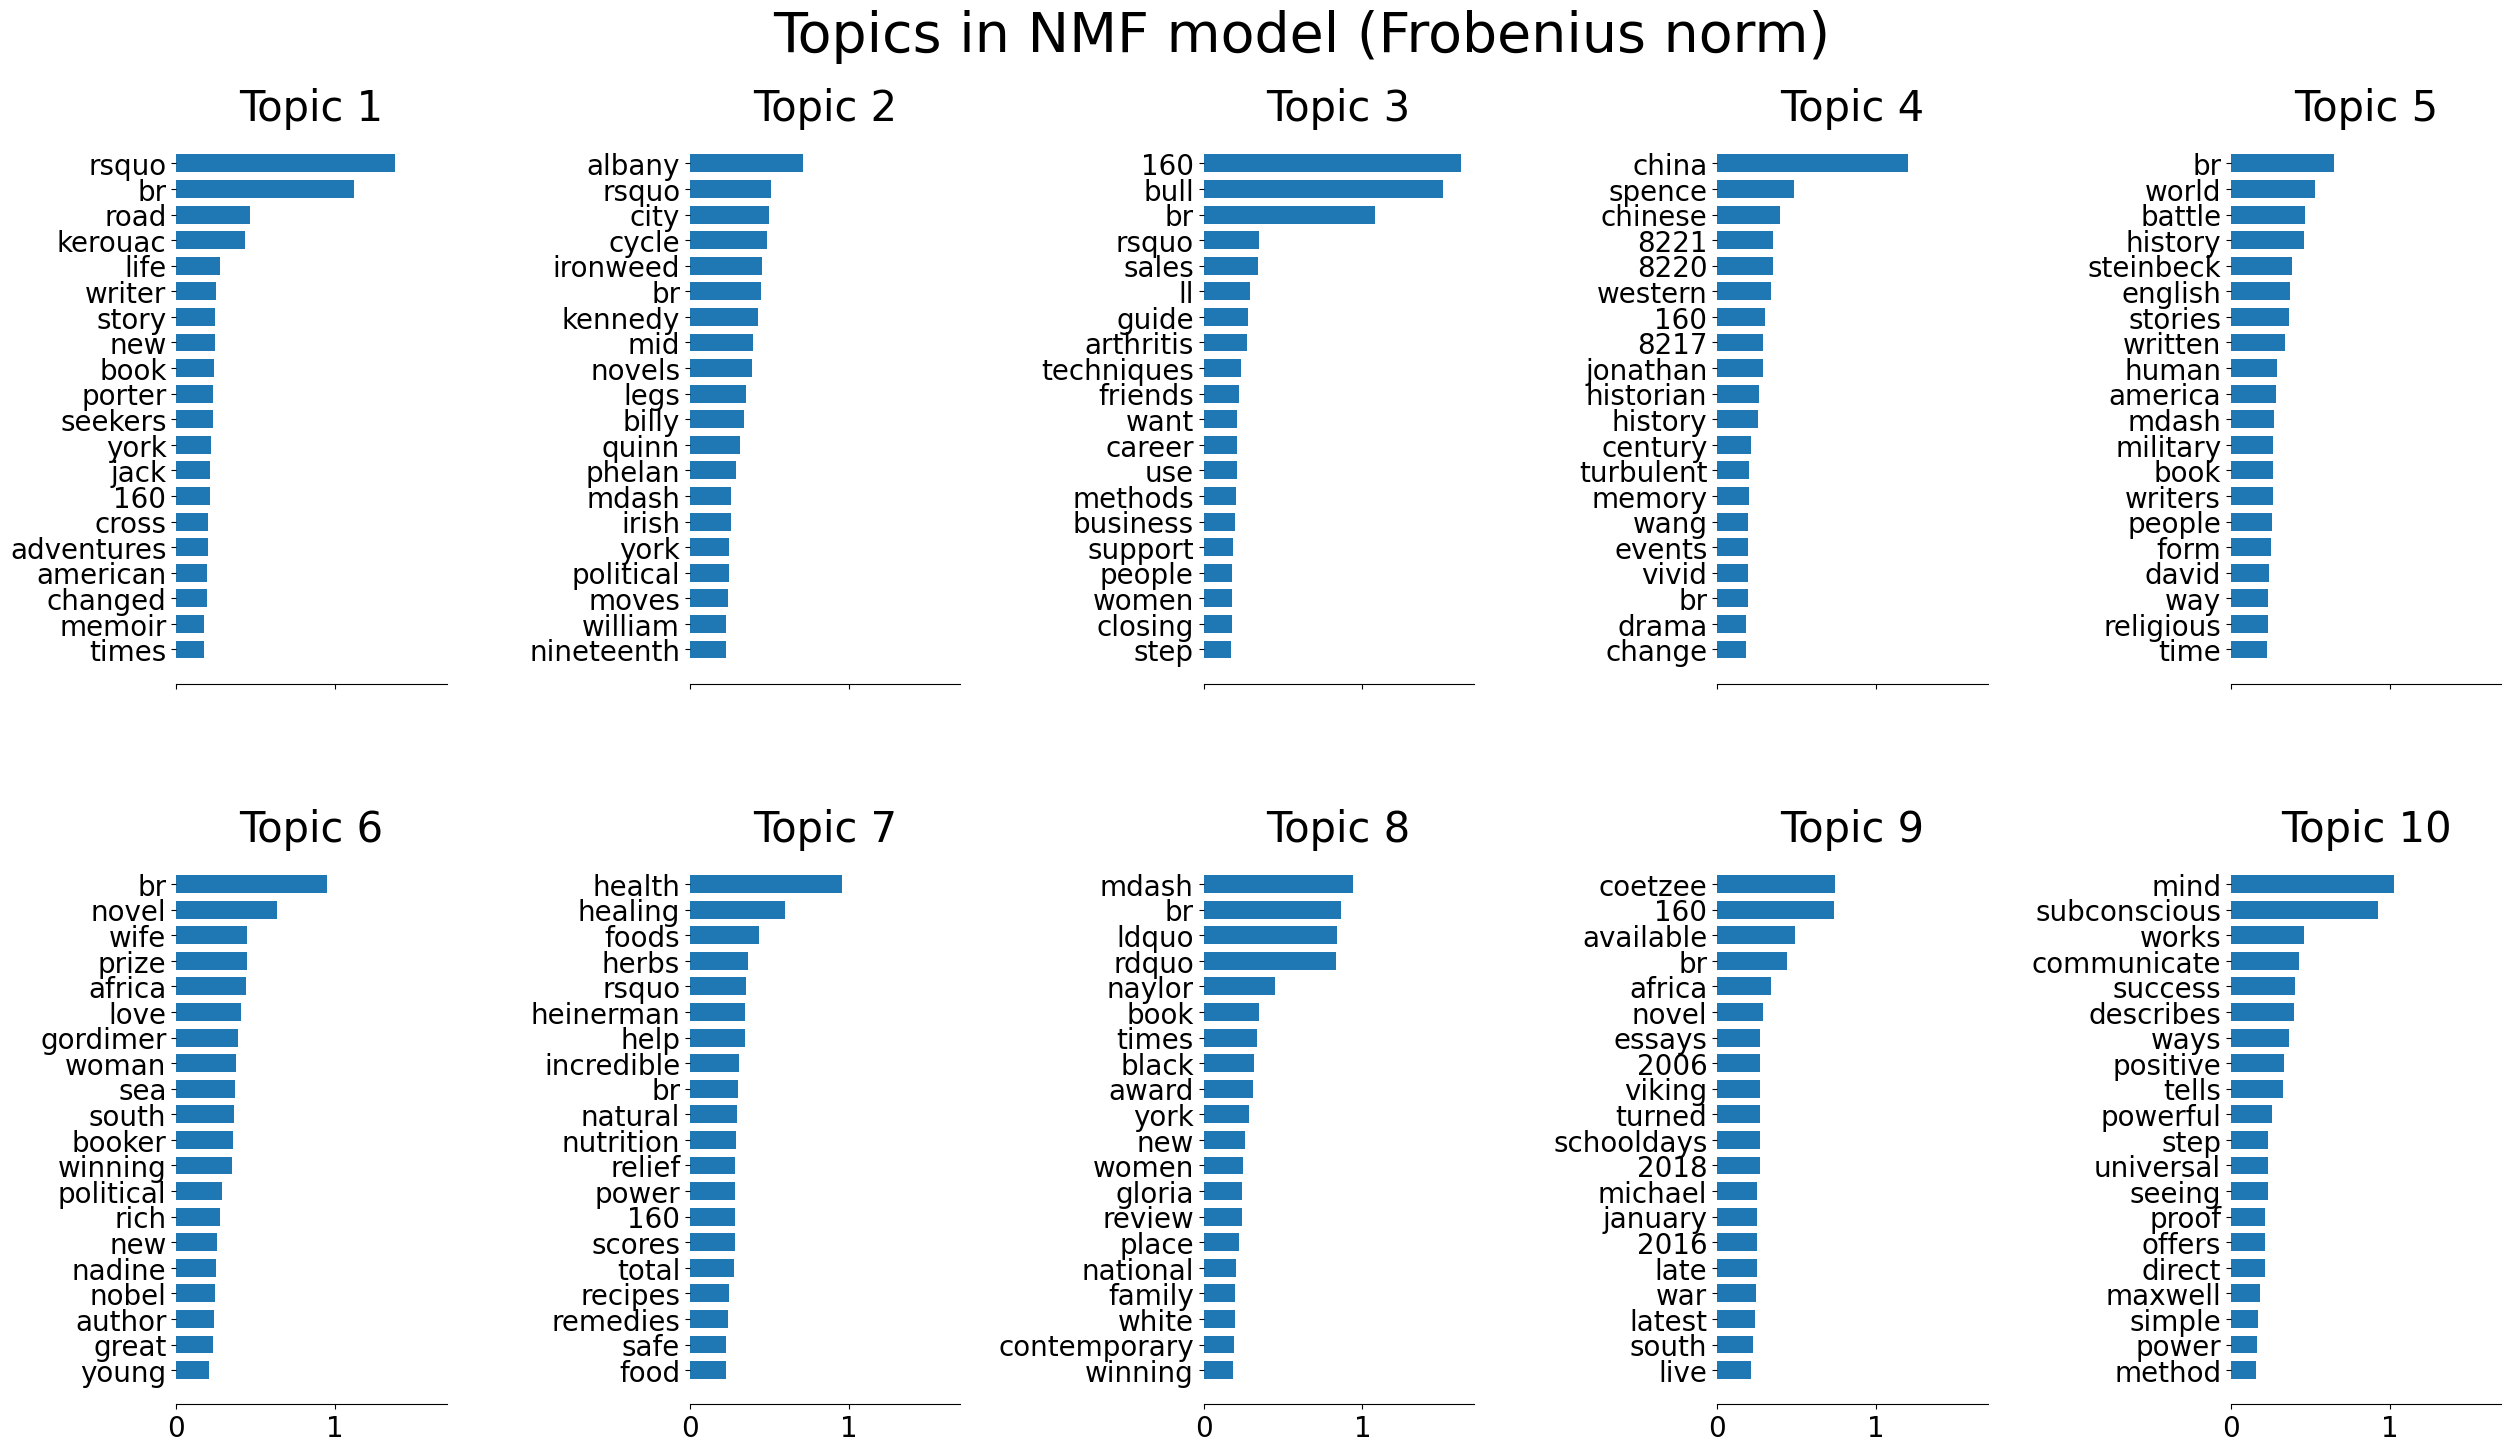



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


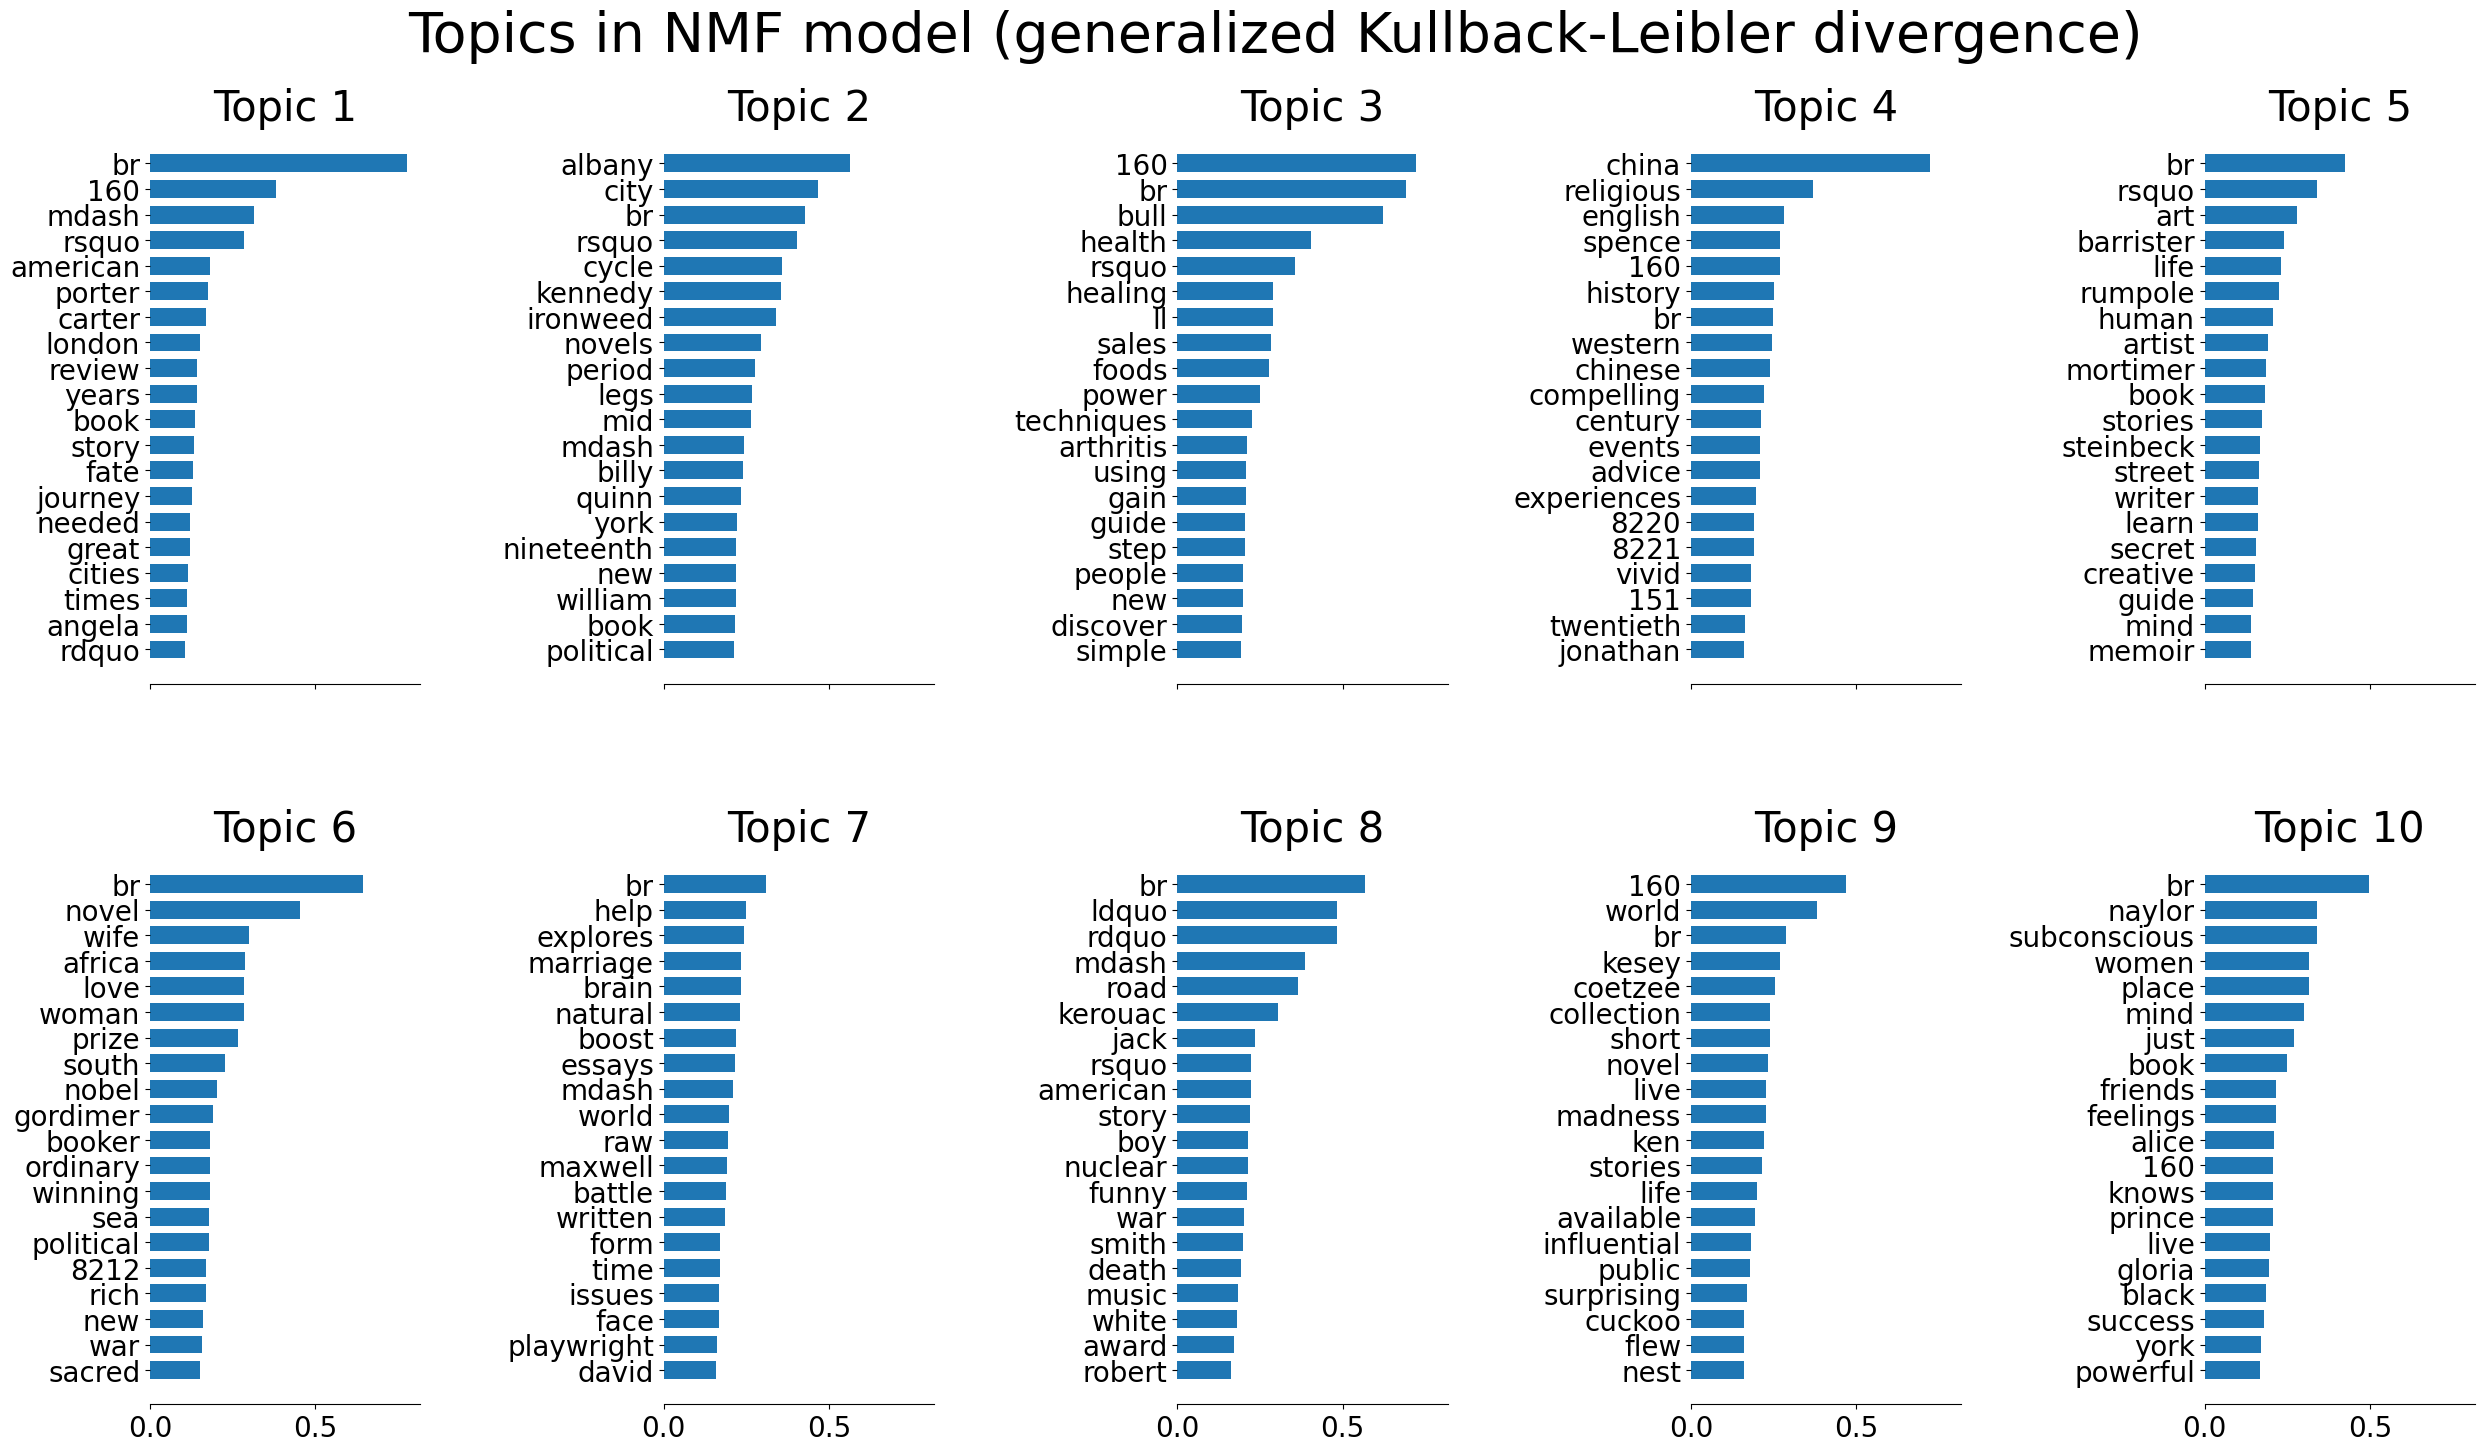



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:2314: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


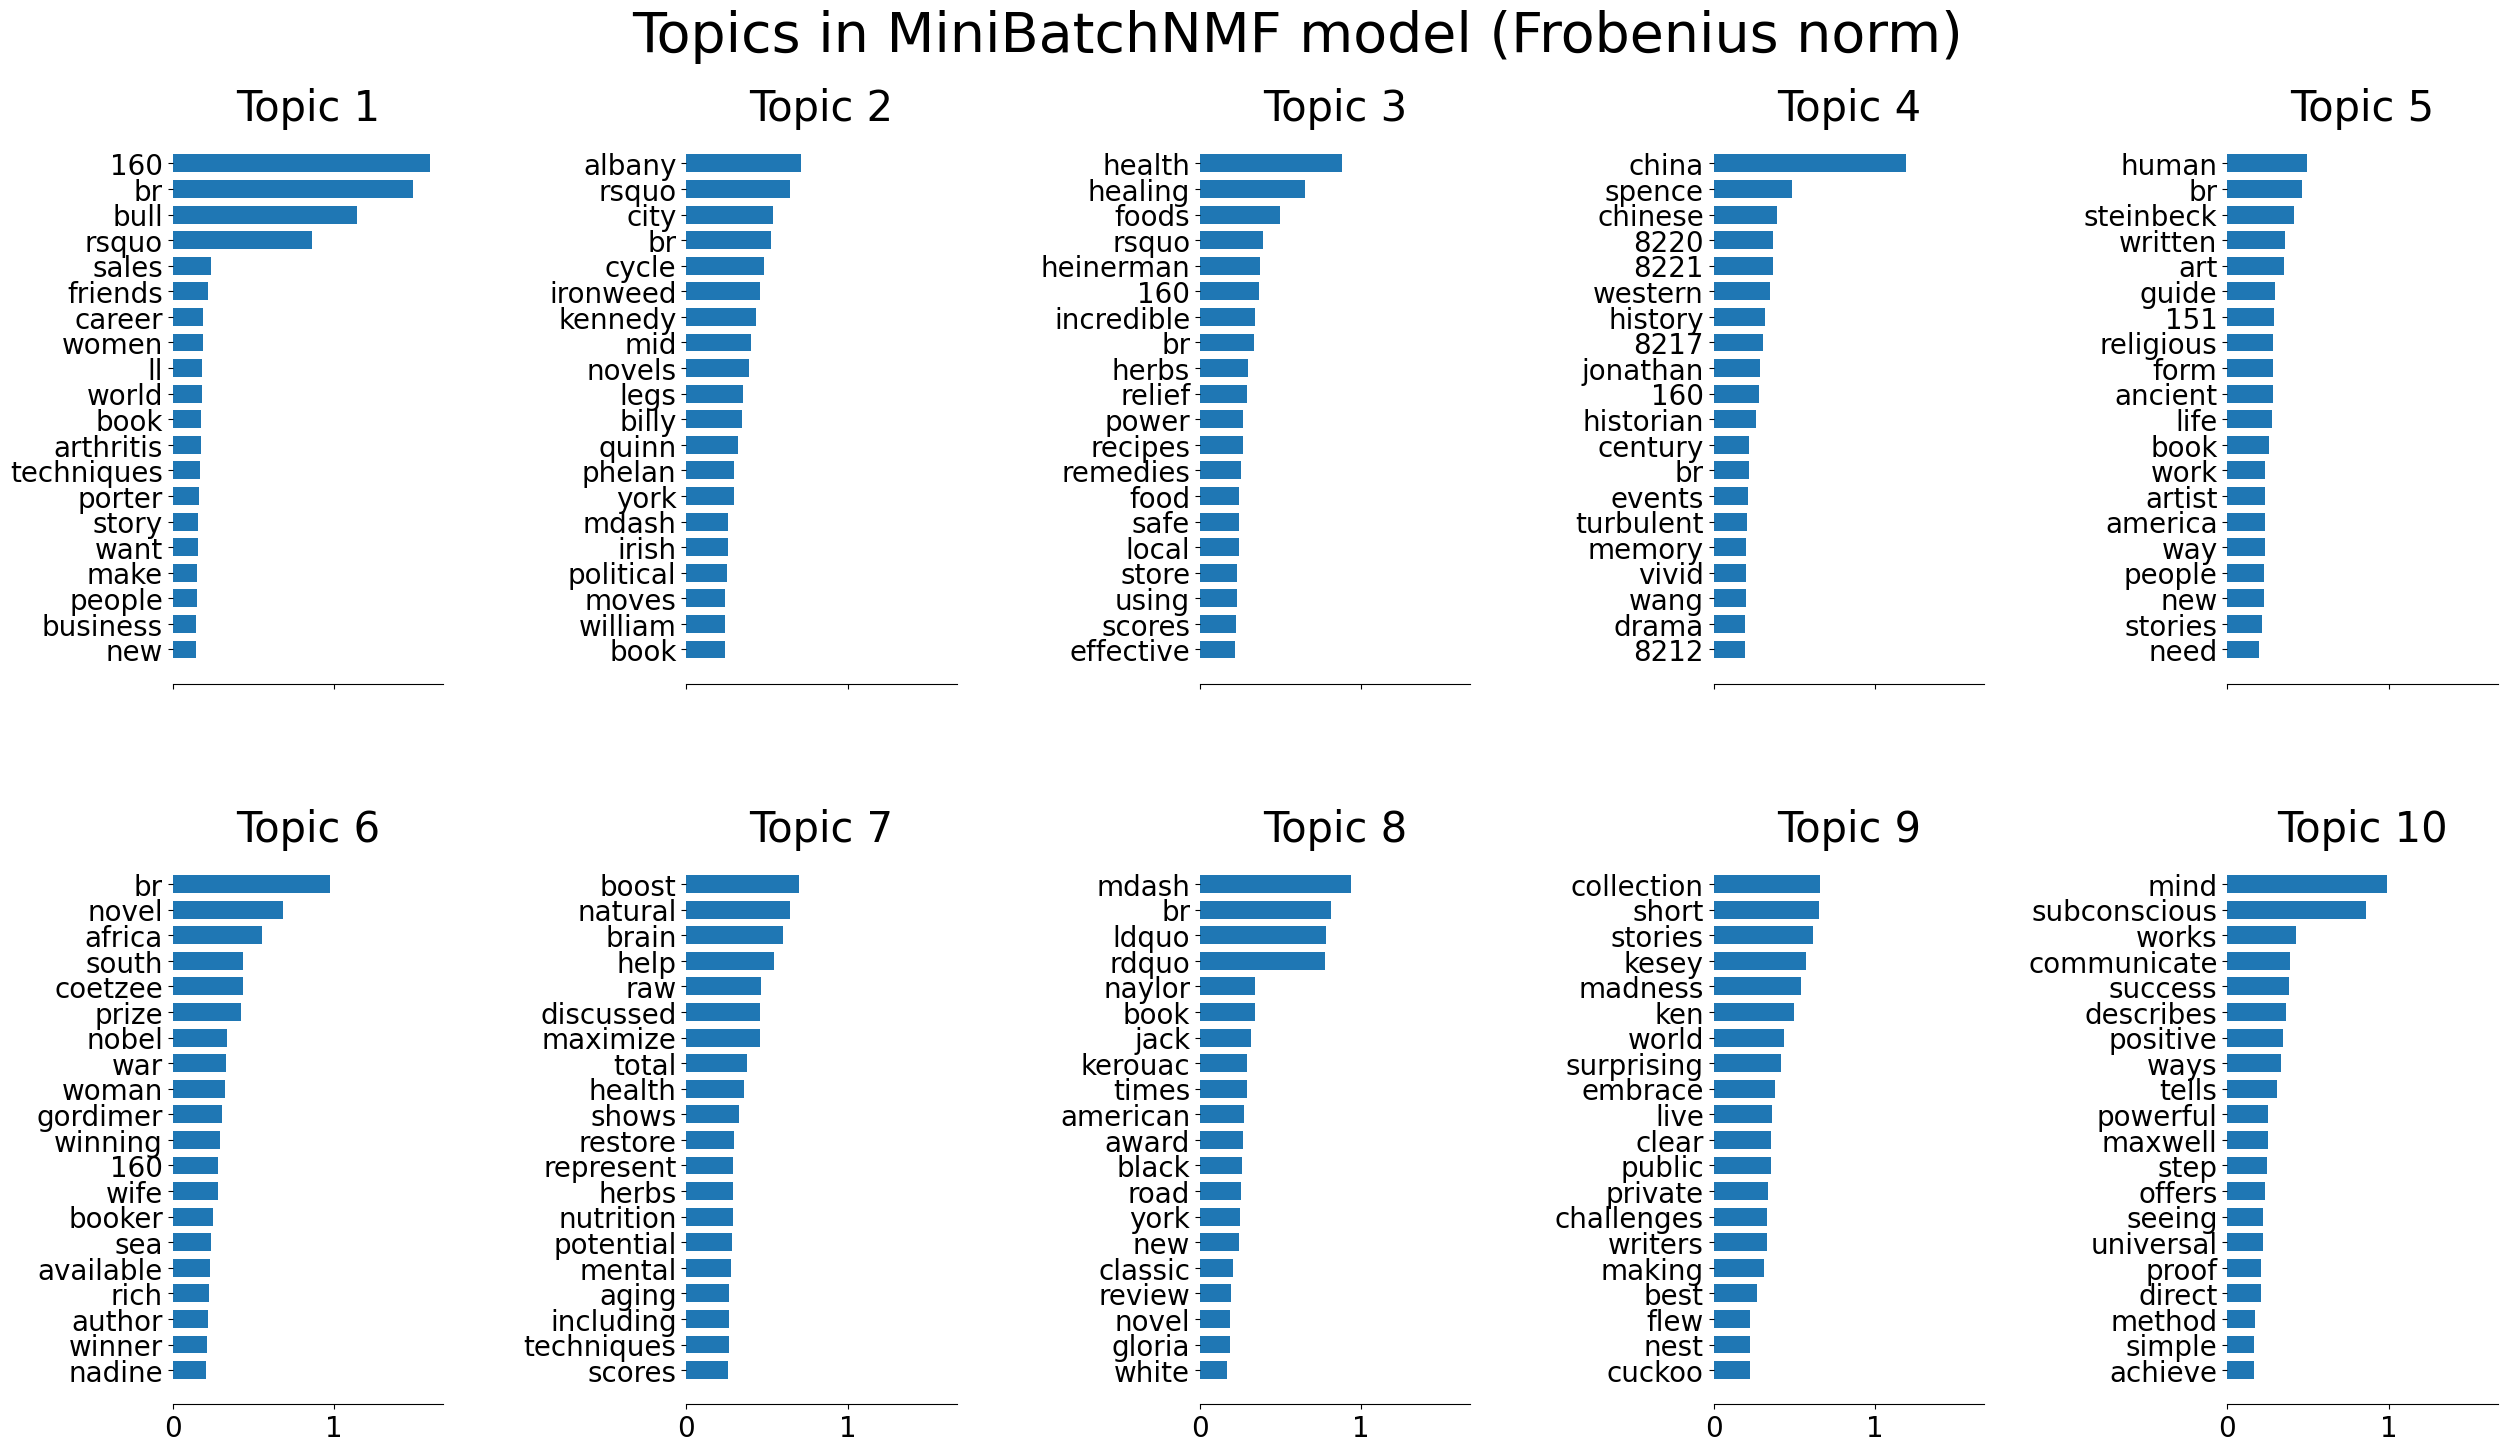



 Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


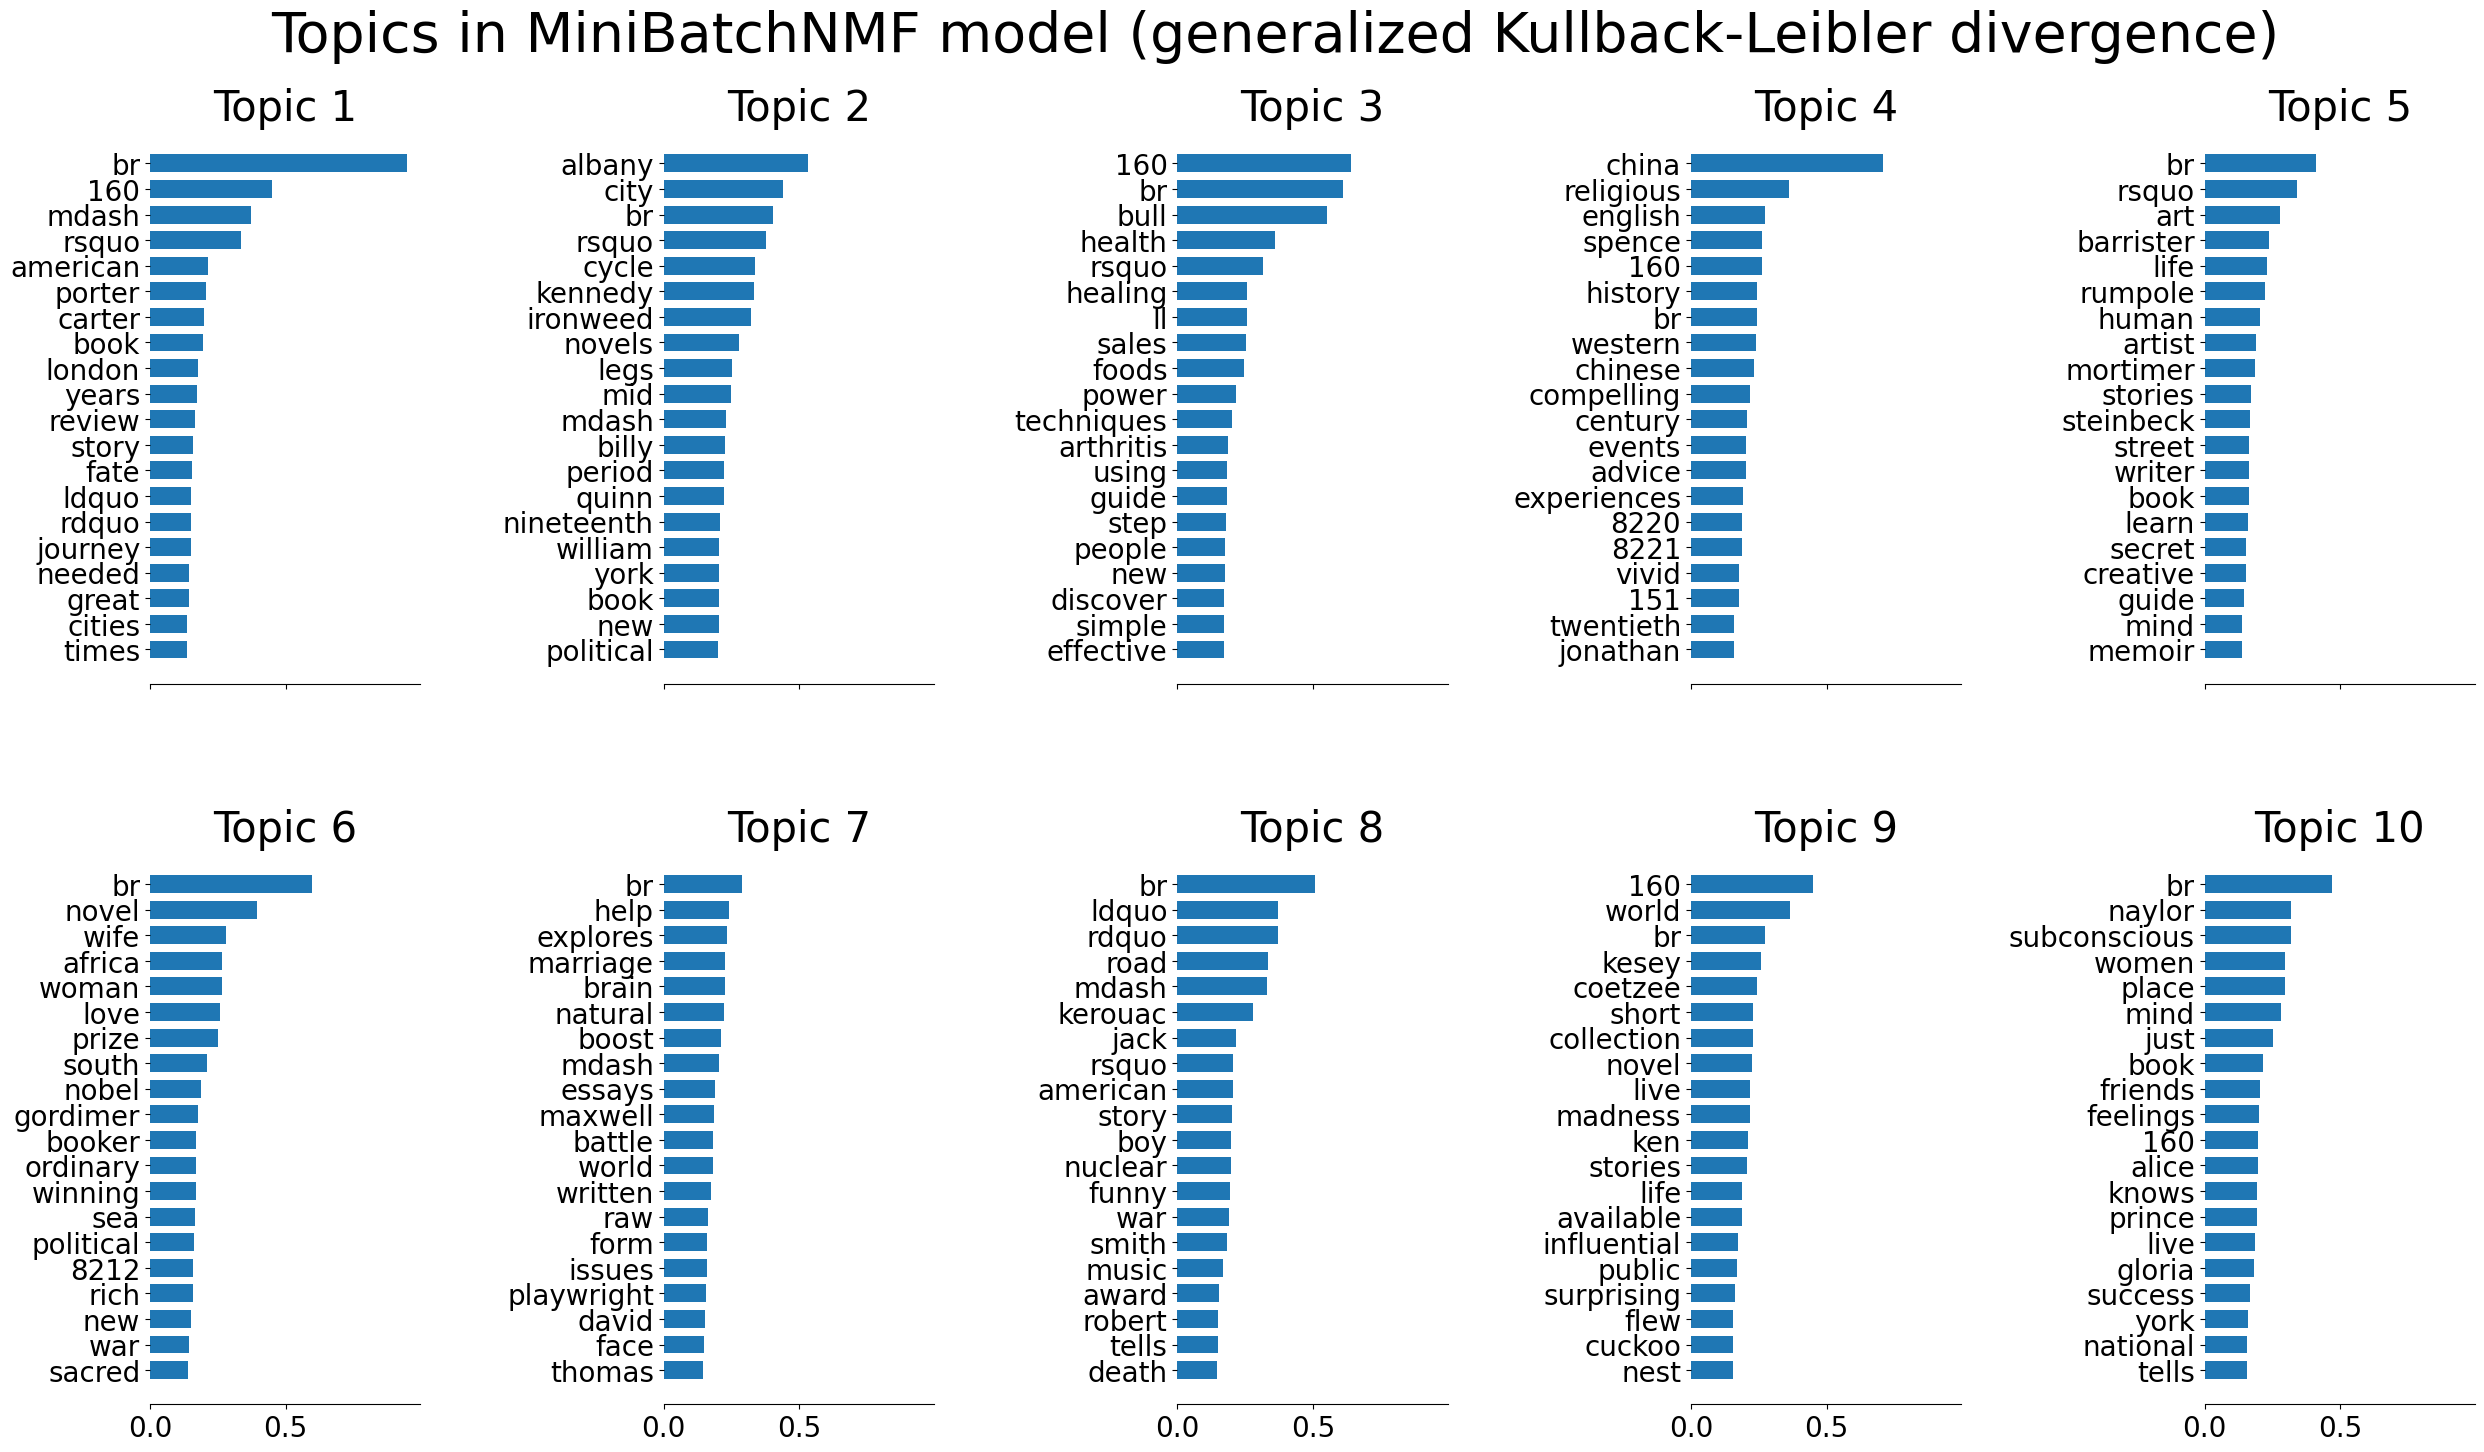



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


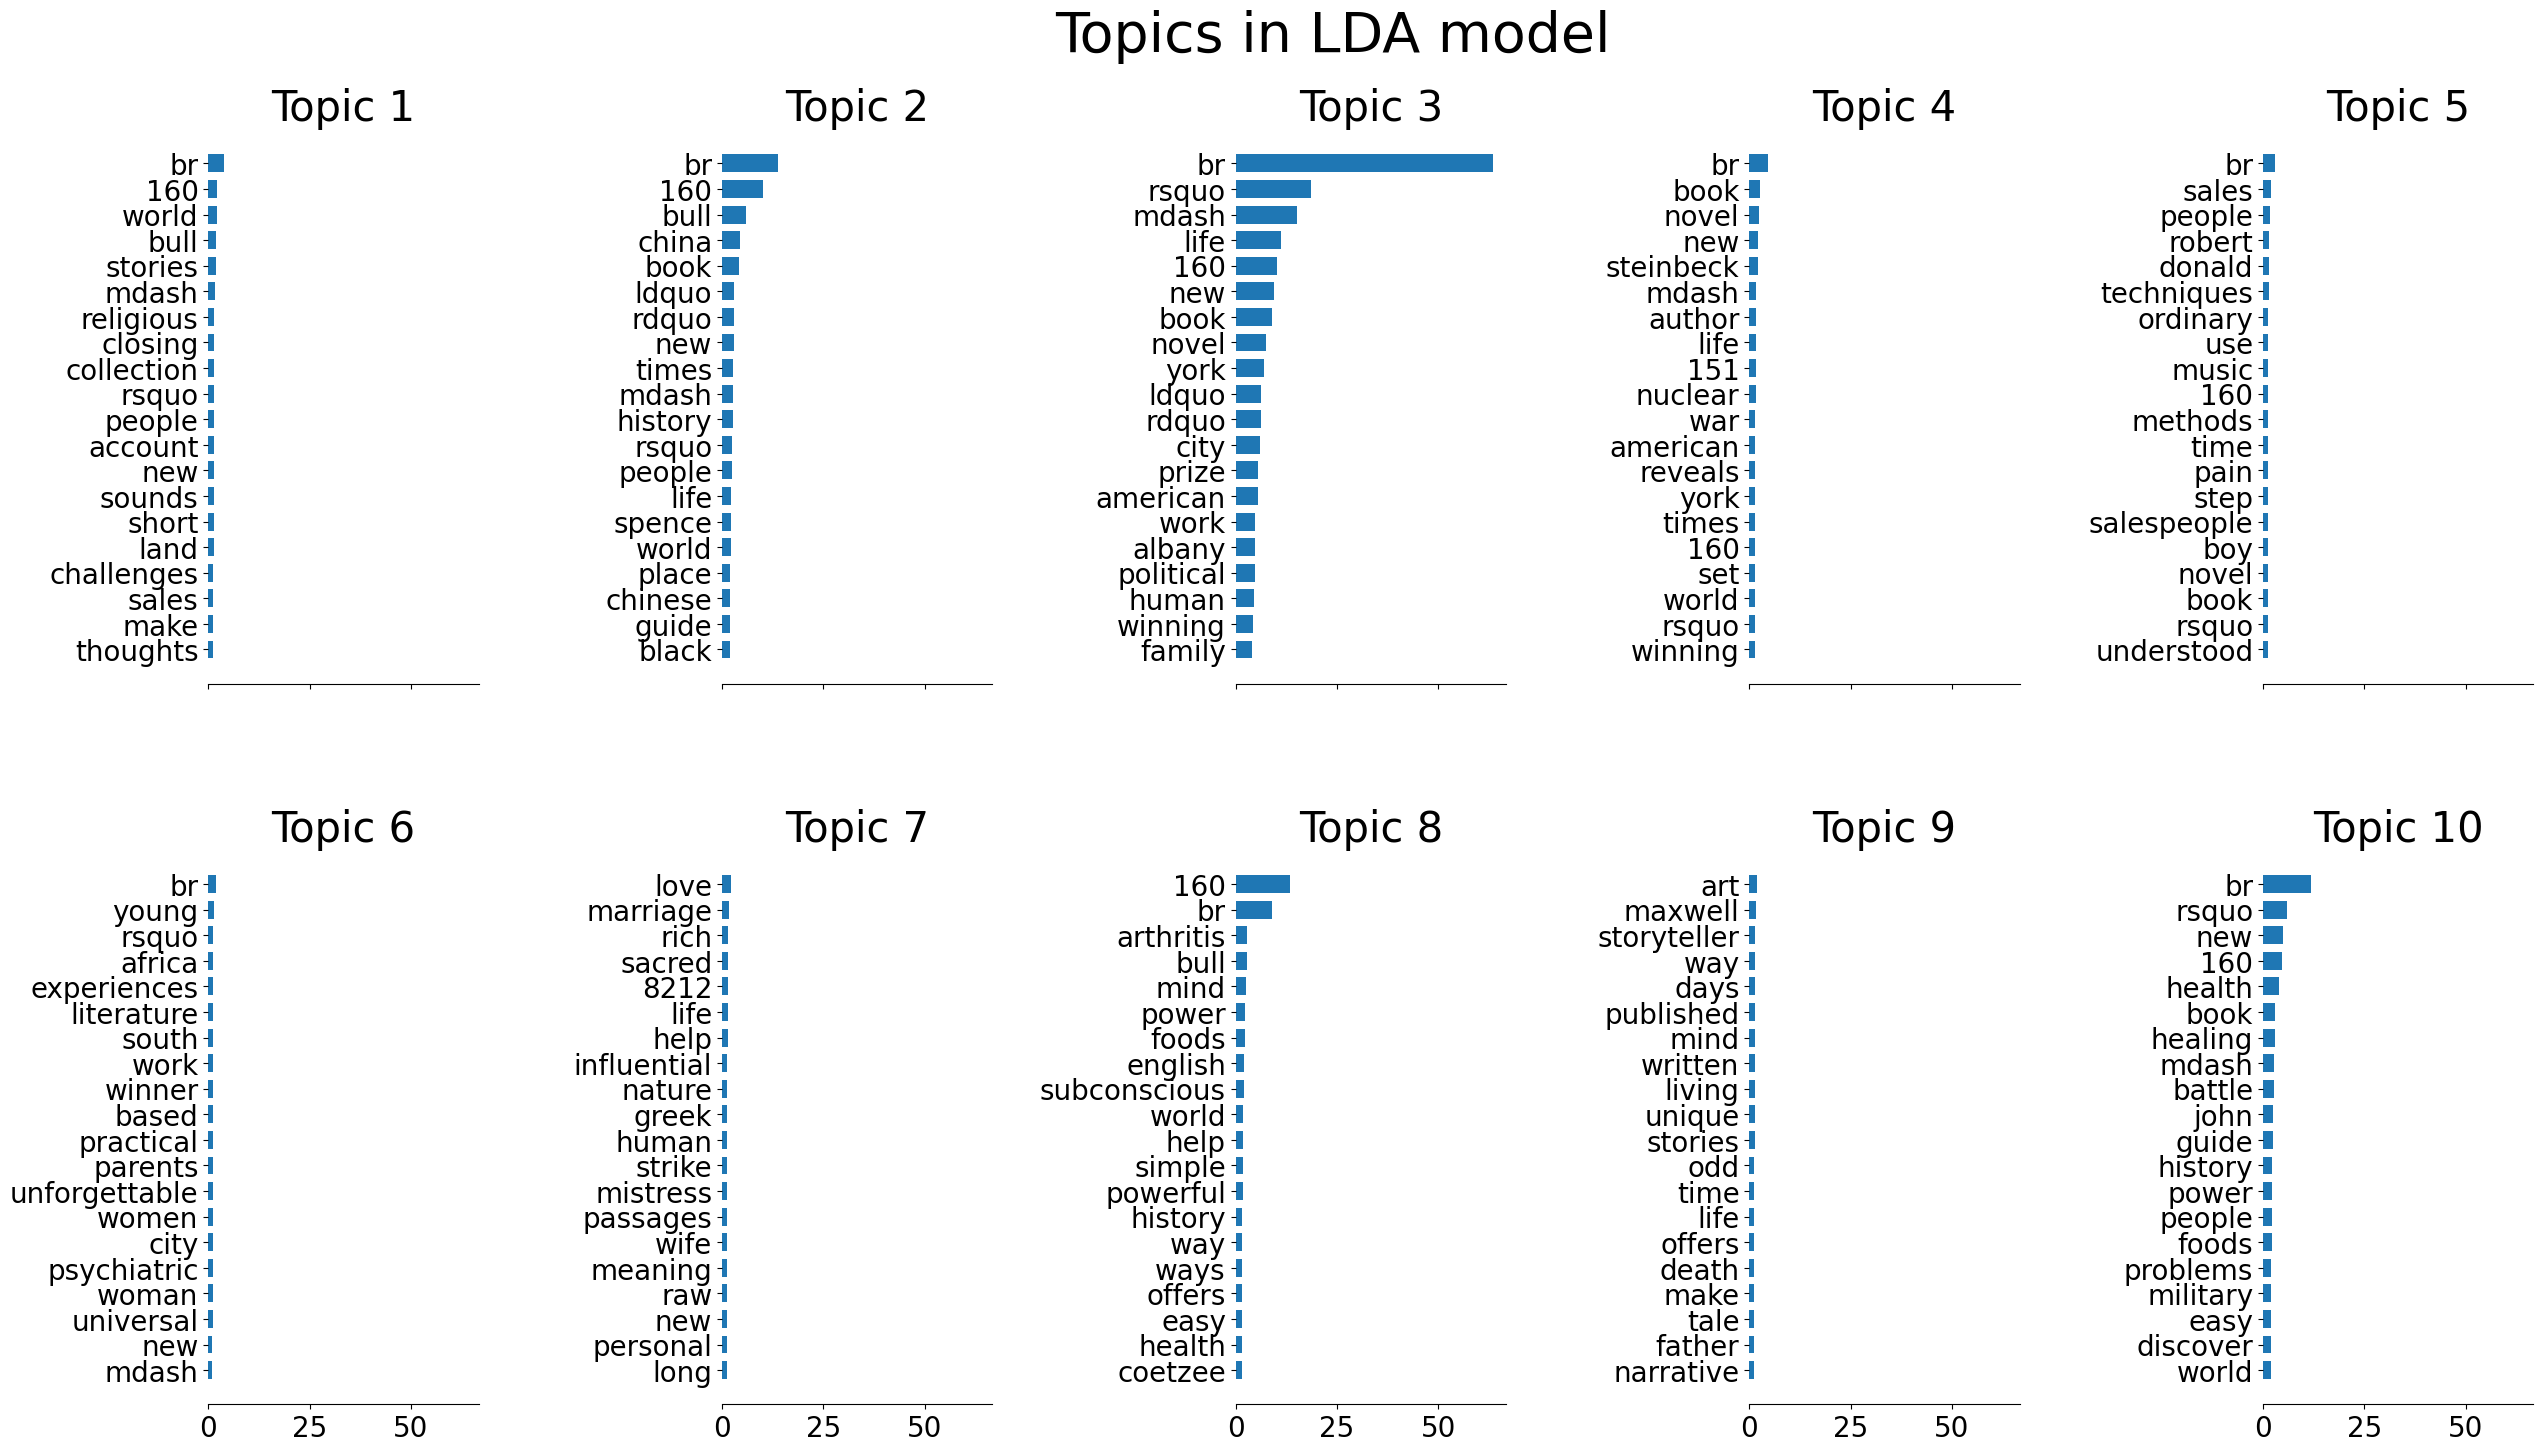

In [56]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt

from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(corpus)

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(corpus)

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

# Fit the NMF model
print(
    "\n" * 2,
    "Fitting the NMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### NMF Document-Topic | Topic-Word

In [57]:
corpus

0     You're not idiot, of course. You can serve up ...
1     This publication shows how raw, natural juices...
2     From apples (sunburn relief) and avocados (car...
3     How can some people come to believe that their...
4     This book is your total guide to using the inc...
                            ...                        
95    This memoir tells the remarkable story of how ...
96    This volume contains twenty tales featuring be...
97    "An absolutely unique voice...It would be an i...
98    When your best friend makes you angry, why can...
99    <b>"Essays in direct line from Stanislavsky, C...
Name: description, Length: 100, dtype: object

In [59]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = X.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

nmf = NMF(n_components=2, random_state=42)
W = nmf.fit_transform(tf_idf_df)
H = nmf.components_

print("Document-Topic Matrix:\n", W)
print("Topic-Word Matrix:\n", H)

Document-Topic Matrix:
 [[5.00784034e-02 0.00000000e+00]
 [4.02626967e-02 0.00000000e+00]
 [2.25679580e-01 0.00000000e+00]
 [1.31301070e-01 0.00000000e+00]
 [2.23956053e-01 1.19770762e-02]
 [3.39398803e-01 0.00000000e+00]
 [3.09211353e-01 0.00000000e+00]
 [1.34390681e-01 2.51535827e-02]
 [5.11017114e-02 0.00000000e+00]
 [2.34456117e-01 0.00000000e+00]
 [9.17194536e-02 0.00000000e+00]
 [2.78033698e-02 0.00000000e+00]
 [3.52444494e-01 0.00000000e+00]
 [9.79902947e-02 0.00000000e+00]
 [2.69983970e-01 0.00000000e+00]
 [1.23351200e-01 0.00000000e+00]
 [1.25908521e-01 2.46753896e-02]
 [5.86727158e-02 0.00000000e+00]
 [1.13825147e-01 0.00000000e+00]
 [7.26506981e-02 6.05629216e-02]
 [8.43849980e-02 0.00000000e+00]
 [1.05703348e-01 2.59612607e-02]
 [1.22026108e-01 0.00000000e+00]
 [1.68804774e-01 0.00000000e+00]
 [1.04768274e-01 1.10220074e-03]
 [3.63744854e-02 0.00000000e+00]
 [9.42570142e-02 7.73830069e-02]
 [1.01717521e-01 0.00000000e+00]
 [1.32559624e-01 1.15027660e-01]
 [1.64329151e-01 9.

In [60]:
tf_idf_df

,000,10,100,1066,151,1577,160,16th,1776,1777,...,younger,yucca,zarathustra,zeal,zealand,zen,zero,zestful,zone,zones
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.000000,0.085236,0.0,0.0,0.0,0.0,0.097538,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.085236,0.0,0.0,0.085236
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.111698,0.000000,0.0,0.0,0.0,0.0,0.085213,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
96,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
97,0.000000,0.000000,0.0,0.0,0.0,0.0,0.037858,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
98,0.000000,0.000000,0.0,0.0,0.0,0.0,0.266963,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [71]:
# 1. Instantiate and fit the TfidfVectorizer
# Common parameters: remove english stopwords, set max features to limit matrix size
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# 2. Fit and transform the documents into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Get the feature names (words) for later topic interpretation
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)

# 3. Instantiate the NMF model (specify the number of topics)
n_topics = 5 
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas") # random_state for reproducibility

# 4. Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tf_idf_df)

# The 'H' matrix (topic-term distribution) is in nmf_model.components_
# The 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 10
print_top_words(nmf_model, feature_names, n_top_words)

Topic #0:
br mdash rdquo ldquo novel africa prize south 160 winning
Topic #1:
albany rsquo city br cycle ironweed kennedy mid novels legs
Topic #2:
160 bull br rsquo health foods healing arthritis guide power
Topic #3:
china spence 8221 8220 chinese history western ricci 160 8217
Topic #4:
br rsquo life road stories book steinbeck human american kerouac



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [72]:
nmf_model.components_

array([[0.        , 0.        , 0.2072801 , ..., 0.10781013, 0.        ,
        0.04920445],
       [0.        , 0.01555596, 0.        , ..., 0.00769099, 0.        ,
        0.        ],
       [0.04758801, 0.        , 0.80747324, ..., 0.00147936, 0.        ,
        0.        ],
       [0.        , 0.02756755, 0.16339102, ..., 0.00506273, 0.00218313,
        0.        ],
       [0.        , 0.07040324, 0.00122778, ..., 0.04632277, 0.02793233,
        0.        ]], shape=(5, 1000))

In [73]:
nmf_model.transform(tfidf_matrix)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


,nmf0,nmf1,nmf2,nmf3,nmf4
0,0.000000,0.000000,0.045652,0.000000,0.057717
1,0.000000,0.000000,0.130550,0.000000,0.000000
2,0.000000,0.008420,0.363985,0.000000,0.000000
3,0.044994,0.000000,0.017231,0.023367,0.201000
4,0.000000,0.042716,0.341334,0.000000,0.000000
...,...,...,...,...,...
95,0.002043,0.020608,0.030765,0.000000,0.298873
96,0.000000,0.006526,0.055403,0.000000,0.282401
97,0.082119,0.008327,0.000000,0.000000,0.261439
98,0.072375,0.012130,0.299171,0.000000,0.100185
